In [62]:
import os, sys
from pathlib import Path
import urllib.request

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import nltk
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
tv_show = "avatar"

In [14]:
nltk.download('punkt')

root_path = Path().resolve().joinpath("..")
show_data_path = root_path.joinpath("scrape", "data", tv_show, "parsed")
embeddings_path = root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors.gz")
embeddings_url = "https://www.dropbox.com/s/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz?dl=1"

if not os.path.isfile(embeddings_path):
    print("downloading embeddings...")
    urllib.request.urlretrieve(embeddings_url, embeddings_path)

!gunzip {str(embeddings_path)}

[nltk_data] Downloading package punkt to /Users/andy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
dialog_datas = []

for filename in os.listdir(show_data_path):
    dialog_data = pd.read_csv(show_data_path.joinpath(filename), header=None, names=("speaker", "utterance"))
    dialog_datas.append(dialog_data)
    
all_dialog_data = pd.concat(dialog_datas).dropna().reset_index(drop=True)

In [17]:
print(all_dialog_data.count())
all_dialog_data.head()

speaker      10356
utterance    10356
dtype: int64


,speaker,utterance
0,Sokka,"So, what kind of trouble is Katara in?"
1,Aang,"I don't know. In my vision, I just knew she ne..."
2,Sokka,It would be nice if your Avatar powers could b...
3,Sokka,What is that?!
4,Sokka,Need a ride?


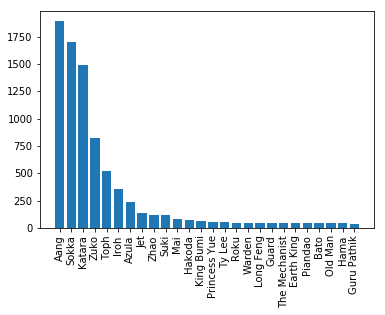

In [18]:
speaker_value_counts = all_dialog_data.speaker.value_counts()
major_speaker_value_counts = speaker_value_counts[speaker_value_counts > 40]
x, y = major_speaker_value_counts.index, major_speaker_value_counts.values
plt.bar(x, y)
plt.xticks(x, x, rotation="vertical")
plt.show()

In [19]:
num_major_characters = 7
major_characters = set(x[:7])

In [20]:
major_characters

{'Aang', 'Azula', 'Iroh', 'Katara', 'Sokka', 'Toph', 'Zuko'}

In [21]:
major_dialog_data = all_dialog_data[all_dialog_data.speaker.isin(major_characters)]
print(major_dialog_data.count())

speaker      7020
utterance    7020
dtype: int64

In [66]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()

labels = major_dialog_data.speaker

utterances = np.array(list(map(tokenizer.tokenize, major_dialog_data.utterance)))
embeddings = KeyedVectors.load_word2vec_format(root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors"), binary=False)

In [67]:
bags = np.zeros((major_dialog_data.utterance.count(), embeddings.vector_size))

for i, utterance in enumerate(utterances):
    bag = np.sum(embeddings.word_vec(word) for word in utterance if word in embeddings.vocab)
    if type(bag) == np.ndarray:
        bags[i, :] = bag

train_cut = math.ceil(major_dialog_data.utterance.count() * 0.8)
train_x = bags[0:train_cut]
train_y = labels[0:train_cut]
test_x = bags[train_cut:]
test_y = labels[train_cut:]

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.


(5616, 300) (5616,) (1404, 300) (1404,)


In [68]:
model = LogisticRegression(multi_class="ovr")
model.fit(train_x, train_y)
model.score(test_x, test_y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.26353276353276356